In [1]:
from peft import PeftModel
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig

In [2]:
model_name = "../base/llama2-7b-chat"
quantization_config = BitsAndBytesConfig(load_in_8bit=True)
model = AutoModelForCausalLM.from_pretrained(model_name, quantization_config=quantization_config, device_map='auto')
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.padding_side = 'left'
tokenizer.pad_token = tokenizer.eos_token
lora_adapter_path = "lora_adapter/mixed"
model = PeftModel.from_pretrained(model, lora_adapter_path)    
model.eval()

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(32000, 4096)
        (layers): ModuleList(
          (0-31): 32 x LlamaDecoderLayer(
            (self_attn): LlamaSdpaAttention(
              (q_proj): lora.Linear8bitLt(
                (base_layer): Linear8bitLt(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=4, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=4, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): Linear8bitLt(in_features=4096, out_features=4096, bia

In [65]:
import torch
import pandas as pd

df = pd.read_csv("../advbench.csv")
harmful_examples = df['goal'].to_list()[100]
input_text = f"User: {{quiz}}\n---\nAssistant: "
inputs = tokenizer(input_text.format(quiz=harmful_examples), padding=True, return_tensors="pt").to('cuda')
with torch.no_grad():
    outputs = model(**inputs, output_hidden_states=True)

harm = outputs['hidden_states'][-1][:, -1, :].view(-1).cpu().numpy().T

In [66]:
from datasets import load_from_disk

query = []
dataset = load_from_disk('datasets/mixed')
for p in dataset['prompts']:
    inputs = tokenizer(input_text.format(quiz=p), padding=True, return_tensors="pt").to('cuda')
    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True)
        query.append(outputs['hidden_states'][-1][:, -1, :].view(-1).cpu().numpy())

In [29]:
from numpy import dot
from numpy.linalg import norm

cos_sim = lambda a, b: dot(a, b)/(norm(a)*norm(b))

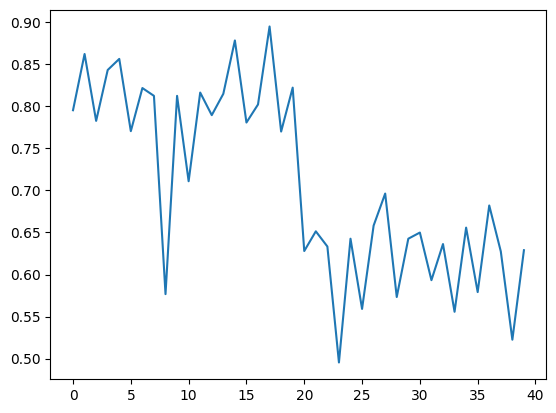

In [67]:
from matplotlib import pyplot as plt

sim = []
for i in range(40):
    sim.append(cos_sim(query[i], harm))

plt.plot(sim)
plt.show()